# Module 5 Training

Our training from before could really use some improvement, but we kept it simple! The first thing we can do is get a better idea of how well our network is doing. 

Why do we need to change the way we evaluate? Before, when we trained, we included the data that we then used to evaluate. This is basically cheating because it has already learned from the test data so of course it's going to do well on it. Imagine being shown 5 dog pictures, then immediately after inspecting them, you are shown one of those 5 images again and asked to classify it. Of course you would have no trouble.

This is where train test comes in. We split the data into a big piece and a small piece. We set aside the small piece and don't use it when training. Therefore, when we want to evaluate the network, we have a true measure of it's performance.

For instance, if we're trying to learn about dogs by looking at pictures, then we can learn different features of dogs from the pictures like four legs, furry, big ears, and a tail. Now if you see a new picture of a dog with no tail and very short fur, you might not recognize it. This is the purpose of the test set. There may be features of the dog that we didn't pick up from the original pictures, but are present in the test set. If this is the case then we (or our network) have not learned enough about dogs to make good classifications and we need to keep learning.

Let's try withholding some data from the network and use it only to evaluate. 

In [2]:
from sklearn.preprocessing import normalize
from sklearn.datasets import load_boston
# here I've moved all our functions to a file so we can just worry about training
from network import Layer, Network, avg_cost, show_predictions, cost, train

dataset = load_boston()
house_features = normalize(dataset.data)
house_prices = dataset.target
                
    
# the size of our test data
test_size = 20

# here we'll withold 20 examples to evaluate against
train_set = house_features[0:-test_size]
train_labels = house_prices[0:-test_size]


# this is what we use to evaluate the network
test_set = house_features[-test_size:]
test_labels = house_prices[-test_size:]

num_inputs_l1 = len(house_features[0])
num_inputs_l2 = 5

l1 = Layer(num_inputs_l1, num_inputs_l2)
l2 = Layer(num_inputs_l2, num_inputs_l2)
l3 = Layer(num_inputs_l2, 1)

net = Network(l1, l2, l3)

learning_rate = .00008

print('average cost: {:.2f}'.format(avg_cost(test_set, test_labels, net.predict, cost)))

print('prediction\tactual')
for (x, y) in zip(test_set, test_labels):
    a = net.predict(x)
    print('{:.1f}\t\t{}'.format(a[0], y))

train(net, train_set, train_labels, 10, learning_rate)

print('average cost: {:.2f}'.format(avg_cost(test_set, test_labels, net.predict, cost)))

print('prediction\tactual')
for (x, y) in zip(test_set, test_labels):
    a = net.predict(x)
    print('{:.1f}\t\t{}'.format(a[0], y))

print('finished')

average cost: 178.95
prediction	actual
0.1		19.1
0.1		20.6
0.1		15.2
0.1		7.0
0.1		8.1
0.1		13.6
0.1		20.1
0.1		21.8
0.1		24.5
0.1		23.1
0.1		19.7
0.1		18.3
0.1		21.2
0.1		17.5
0.1		16.8
0.1		22.4
0.1		20.6
0.1		23.9
0.1		22.0
0.1		11.9
average cost: 10.46
prediction	actual
18.8		19.1
18.8		20.6
18.6		15.2
18.3		7.0
18.2		8.1
18.6		13.6
18.7		20.1
19.9		21.8
19.9		24.5
19.9		23.1
19.9		19.7
19.9		18.3
19.9		21.2
19.9		17.5
19.9		16.8
20.4		22.4
20.4		20.6
20.4		23.9
20.4		22.0
20.4		11.9
finished


## K-Fold Cross Validation

We can take train test a step further and essentially repeat it multiple times. This allows us to get an even more accurate measure of how well our network performs. K folds refers to splitting the data into K, roughly equal sized, pieces and doing train test witholding one of the K folds each time. Therefore, we run train test K times where each time we withold a different piece. 

After each run where we evaluate the model against a single fold, we discard the model and start over with a new piece. Because we discard the model each time we are basically starting over. The reason for this is to get a more representative idea of how well the model performs. Instead of just 1 score on data we've never seen, we can now have K scores and take the average and standard deviation. 

In [4]:
import numpy as np
from statistics import mean, stdev
from network import avg_cost, cost

# this function will chop up our data set for us. 
# we can specify the number of chunks and whether to shuffle
# the data and it will give us back a bunch of indicies
# that we can use to grab features and labels from our
# entire dataset. This allows us to not have to worry about
# how to slice the data set up into roughly equal sized 
# pieces and withold a different piece each time
from sklearn.model_selection import KFold

# K is the number of groups we will divide the input data into
K = 10

# the number of times we go through the entire dataset
epochs = 50

# this is an array where we will save the cost from each of our K runs
costs = np.zeros(K)


# Here we shuffle the data to prevent the network from learning 
# any patterns that may be present because of the ordering
kfolder = KFold(K, shuffle=True)

print('This takes a while. The current progress is shown below')
print('batch: ', end='')
for ( cost_idx, (train_idxs, test_idxs)) in enumerate(kfolder.split(house_features, house_prices)):
    print('{} '.format(cost_idx+1), end='')
    train_features, train_labels = house_features[train_idxs], house_prices[train_idxs]
    test_features, test_labels = house_features[test_idxs], house_prices[test_idxs]
    
    # create the new model to train
    net = Network(l1, l2, l3)
    
    train(net, train_features, train_labels, epochs, learning_rate)
    
    costs[cost_idx] = avg_cost(test_features, test_labels, net.predict, cost)
    

print()
print(costs)
print('average cost: {}'.format(mean(costs)))
print('stdev cost: {}'.format(stdev(costs)))
    

This takes a while. The current progress is shown below
batch: 1 2 3 4 5 6 7 8 9 10 
[35.5533847  33.88405697 51.93434829 38.4416392  37.97696573 12.53013948
 38.68964108 21.55089773 23.86084288 33.01003051]
average cost: 32.743194656888264
stdev cost: 10.982442818722244


As you can see, the cost can often vary greatly and in some interations it is very low while others it's very high. If we had not used K fold to validate this, we could have got a very low score and assumed that our network was really good when in actuality it isn't. The lower cost could be due to some ordering of the data that causes the network to fit very well, but we can see that on average the cost changes greatly depending on the train set.


## Stochastic Gradient Descent

All examples we've seen so far have used the gradients for every example to update the weights and biases.  The reason we don't want to use every single point to update is that it can be too noisy. There is going to be natural noise in the data and if our network is trying to fit every single bump and curve it can overfit the data and won't generalize well to new examples.

The way you can think about noise in the housing data is with similar houses. In a given neighborhood there may be several houses that sell for a similar price. Their features will also be very similar, but not exactly the same. Therefore, even though the house features are slightly different, they have a similar price and we would not want the network to give them all very different predictions just because their features are slightly different. 

The other extreme is to take the average across all input gradients and use that average to update. There are two drawbacks to this. One is that it makes learning less efficient. In order for our network to learn anything at all, we must first pass in every single house example. The second drawback is that when we average across the entire dataset we loose information. There may be structure in the house examples that is basically smoothed over by the average. There may be outliers that heavily skew the average and make the mean less accurate.

For example if we have 5 people whose incomes are 45K, 30K, 53K, 36K, and 200K the average income is 72.8K. That means four people fall below the average income and one falls above. That is not a very good representataion because of the outlier. 

The same is true for taking the average across the entire house dataset or any dataset for that matter. All of the predicted prices after training become very close to each other. It's as though the network is just predicting the average house value no matter what input it sees.

Because such a large average is inefficient and poorly represents the data we can take the average across a smaller batch of examples which is referred to as mini-batch gradient descent. Instead of averaging across all input data, we only take the average of a small portion and use that average to update the weights and biases. Using mini-batch gradient descent, our network can learn faster and pickup on more granular patterns in the data.

In [6]:
from network import Network, Layer, avg_cost

def avg_batch_gradients(net, features, labels):
    avg_dC_dws = [np.zeros(shape=l.weights.shape) for l in net.layers]
    avg_dC_dbs = [np.zeros(shape=l.biases.shape) for l in net.layers]
    
    for (x, y) in zip(features, labels):
        dC_dw, dC_db = net.get_gradient(x, y)
        
        for j in range(len(net.layers)):
            avg_dC_dws[j] += dC_dw[j]/len(features)
            avg_dC_dbs[j] += dC_db[j]/len(features)
        
    return avg_dC_dws, avg_dC_dbs

def batch_train(net, features, labels, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        
        num_batches = int(len(features)/batch_size)

        # We iterate over each batch instead of every single training example
        for i in range(num_batches):
            batch_range = range(i*batch_size, (i+1)*batch_size)
    
            dC_dws, dC_dbs = avg_batch_gradients(
                 net, features[batch_range], labels[batch_range])

            # LEARNING!!!
            # update weights and biases
            for j in range(len(net.layers)):
                net.layers[j].weights -= dC_dws[j] * learning_rate
                net.layers[j].biases -= dC_dbs[j].flatten() * learning_rate

                
# the size of our test data
test_size = 20
batch_size = 10
learning_rate = .008
epochs = 50

# here we'll withold 20 examples to evaluate against
train_set, train_labels = house_features[0:-test_size], house_prices[0:-test_size]
test_features, test_labels = house_features[-test_size:], house_prices[-test_size:]

net = Network(
    Layer(13, 8),
    Layer(8, 1))


print('average cost: {:.2f}'.format(
    avg_cost(test_features, test_labels, net.predict, cost)))

print('prediction\tactual')
for (x, y) in zip(test_set, test_labels):
    a = net.predict(x)
    print('{:.1f}\t\t{}'.format(a[0], y))

batch_train(net, train_set, train_labels, epochs, learning_rate, batch_size)

print('average cost: {:.2f}'.format(
    avg_cost(test_features, test_labels, net.predict, cost)))

print('prediction\tactual')
for (x, y) in zip(test_set, test_labels):
    a = net.predict(x)
    print('{:.1f}\t\t{}'.format(a[0], y))

    

average cost: 181.20
prediction	actual
-0.0		19.1
-0.0		20.6
-0.0		15.2
-0.0		7.0
-0.0		8.1
-0.0		13.6
-0.0		20.1
-0.0		21.8
-0.0		24.5
-0.0		23.1
-0.0		19.7
-0.0		18.3
-0.0		21.2
-0.0		17.5
-0.0		16.8
-0.0		22.4
-0.0		20.6
-0.0		23.9
-0.0		22.0
-0.0		11.9
average cost: 8.65
prediction	actual
17.6		19.1
17.7		20.6
17.3		15.2
16.7		7.0
16.3		8.1
17.3		13.6
17.4		20.1
19.9		21.8
19.9		24.5
19.8		23.1
19.6		19.7
19.8		18.3
19.8		21.2
19.7		17.5
19.7		16.8
21.1		22.4
21.1		20.6
21.1		23.9
21.1		22.0
21.1		11.9


## Different Activation Functions

Up until now we have used the linear activation function $y = x$. This is fine if our task is regression. In other words if our network is trying to predict continuous values such as house prices or coordinates. However, if we want our network to perform classification, we don't want it to give us a number we want it to give us a class. Specifically, we want the network to tell us what class the input belongs to and the probability.

For instance if we have a network that can distinguish between dogs, cats, and pigs and we give it an image of a dog, we want the network to say that it is confident the image is a dog by means of a percentage value. For example it might give the dog class output a score of 98% and the other two classes a score of 1%. Interpreting this percentage we might say the network is 98% confident the image is a dog.

To do this type of classification we would need three output neurons from the network and we would have to use an activation function that will only give a value between 0 and 1. For our case we can use the sigmoid function.

Because we have a dataset from scikit learn that includes images of handwritten digits, we will use that for our classification network. The handwritten digits dataset has ten different classes as you can imagine, one for each digit 0-9. Therefore, we need a network with 10 output neurons.

As for the inputs of the network, we are using images, but how do we feed an image into the network? we flatten it into a 1 dimensional array and that array becomes a single row in the dataset. The images have 64 pixels meaning the image when viewed is 8X8 pixels.


In [28]:
%matplotlib notebook
import random as rand
from sklearn.datasets import load_digits
from numpy.linalg import norm

def cost(a, y, derivative=False):
    if derivative:
        return a - y

    return .5*norm(y - a)**2

# The sigmoid function will only output a number between 0 and 1
# which we can use to represent a probability. It also has the
# very nice property that it's derivative is just s(z)*(1-s(z))
# where s is the sigmoid function.


def sigmoid(z, derivative=False):
    s = 1/(1 + np.exp(-z))

    if not derivative:
        return s

    return s*(1-s)


def linear(z, derivative=False):
    if not derivative:
        return z

    return np.ones(shape=z.shape)


class Layer:
    # now we will allow the creation of a layer with the activation function as a parameter
    # that we we can use softmax or any other function instead of just linear
    def __init__(self, num_inputs, num_neurons, activation_fn=linear):
        self.weights = np.random.uniform(-.1, .1,
                                         size=(num_neurons, num_inputs))
        self.biases = np.random.uniform(-.1, .1, size=(num_neurons))
        self.activation = activation_fn
        self.dz_dw = []
        self.da_dz = []

    def predict(self, features):
        z = self.weights.dot(features) + self.biases
        # here we save the activation function gradient to use later
        # when we perform gradient descent for the whole network
        self.da_dz = self.activation(z, derivative=True)
        self.dz_dw = self.activation(z)
        return self.dz_dw


class Network:
    def __init__(self, *layers):
        self.layers = layers
        self.grad_calls = 0
        self.dz_dw = []
        self.da_dz = []

    def get_gradient(self, x, y):
        # find the gradient for a single example
        prediction = self.predict(x)
        dC_da = cost(prediction, y, derivative=True)

        dC_dw = []
        dC_db = []

        for i in range(1, len(self.layers)+1):
            # the line below is the only difference from our previous
            # network. Instead of assuming that da/dz = 1 (which it
            # does for our linear activation layers) we must use the
            # gradient for any activation that the layer has. In this
            # example it is sigmoid for the last layer.
            dC_dz = dC_da * self.da_dz[-i]
            dC_dw.insert(0, np.outer(dC_dz, self.dz_dw[-(i+1)]))
            dC_db.insert(0, dC_dz)
            dC_da = self.layers[-i].weights.transpose().dot(dC_dz)

        self.grad_calls += 1
        return dC_dw, dC_db

    def predict(self, x):
        da_dz = []
        dz_dw = [x]
        prediction = x

        for l in self.layers:
            prediction = l.predict(prediction)
            da_dz.append(l.da_dz)
            dz_dw.append(prediction)

        self.da_dz = da_dz
        self.dz_dw = dz_dw

        return prediction

# label_to_vector takes in a digit lable 0-9
# and turns it into a vector of probabilities
# where all values are 0 except for the label
# index which is 1. For example, if the label
# were 3, our output vector would have 1 at
# index 3 and 0 everywhere else. i.e.
# [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


def label_to_vector(digit):
    probability_vector = np.zeros(10)
    probability_vector[digit] = 1
    return probability_vector

# vector_to_label takes in a vector of probabilities
# where each element corresponds to the probability
# of a digit. For instance, the first value is the
# probability of the input being 0, the second value
# being 1, third being 2, and so on. It finds the
# index with the max probability and returns it.
# Therefore, if our network predicted index 8
# to have the highest value, we would say it has
# predicted the input digit image to be 8. i.e.
# [.01, .02, .31, .22, .14, .06, .02, .1, .93, .4]


def vector_to_label(vec):
    return np.argmax(vec)


def show_predictions(digit_images, digit_labels):
    print('actual\t\tprediction\tcorrect')
    print('------\t\t----------\t-------')
    for (x, y) in zip(digit_images, digit_labels):
        actual = y
        prediction = vector_to_label(net.predict(x))
        print('{}\t\t{}\t\t{}'.format(actual, prediction,
                                      '✓' if actual == prediction else ''))


dataset = load_digits()

digit_images = dataset.data
digit_labels = dataset.target

test_len = 100
test_start = rand.randint(0, len(digit_images)-test_len)
test_set = digit_images[test_start:test_start+test_len]
test_labels = digit_labels[test_start:test_start+test_len]


l1 = Layer(64, 32)
l2 = Layer(32, 16)
l3 = Layer(16, 10, activation_fn=sigmoid)
net = Network(l1, l2, l3)


epochs = 20
batch_size = 5
learning_rate = .008

# the digit labels are the actual digit that the images corresponds to 0-9
# we have to convert this to a vector of probabilities that our network outputs
labels = np.array([label_to_vector(label) for label in digit_labels])
test_label_vectors = [label_to_vector(label) for label in test_labels]

print('cost: {}'.format(avg_cost(test_set, test_label_vectors, net.predict, cost)))
show_predictions(test_set, test_labels)


import matplotlib.pyplot as plt

print('=== TRAINING ===')
batch_train(net, digit_images, labels, epochs, learning_rate, batch_size)

print('cost: {}'.format(avg_cost(test_set, test_label_vectors, net.predict, cost)))
show_predictions(test_set, test_labels)

cost: 1.2681651238437877
actual		prediction	correct
------		----------	-------
0		0		✓
9		0		
5		0		
5		0		
6		1		
5		0		
0		0		✓
9		0		
8		0		
9		0		
8		3		
4		0		
1		0		
7		0		
7		3		
3		3		✓
5		1		
1		3		
0		0		✓
0		0		✓
2		0		
2		0		
7		3		
8		3		
2		0		
0		0		✓
1		0		
2		0		
6		0		
3		0		
3		0		
7		0		
3		0		
3		0		
4		5		
6		1		
6		1		
6		1		
4		9		
9		0		
1		0		
5		3		
0		0		✓
9		0		
5		0		
2		0		
8		0		
2		0		
0		0		✓
0		0		✓
1		0		
7		0		
6		1		
3		0		
2		0		
1		0		
7		0		
4		5		
6		1		
3		0		
1		0		
3		0		
9		0		
1		0		
7		0		
6		1		
8		0		
4		5		
3		0		
1		0		
4		0		
0		0		✓
5		3		
3		0		
6		1		
9		0		
6		1		
1		3		
7		0		
5		3		
4		0		
4		5		
7		3		
2		0		
8		0		
2		0		
2		0		
5		3		
7		0		
9		0		
5		3		
4		5		
8		3		
8		0		
4		5		
9		0		
0		0		✓
8		0		
9		0		
8		0		
=== TRAINING ===
cost: 0.04922616315341001
actual		prediction	correct
------		----------	-------
0		0		✓
9		9		✓
5		5		✓
5		5		✓
6		6		✓
5		5		✓
0		0		✓
9		9		✓
8		8		✓
9		9		✓
8		5		
4		4		✓
1		1		✓
7		7		✓
7	

=== TRAINING ===


<IPython.core.display.Javascript object>


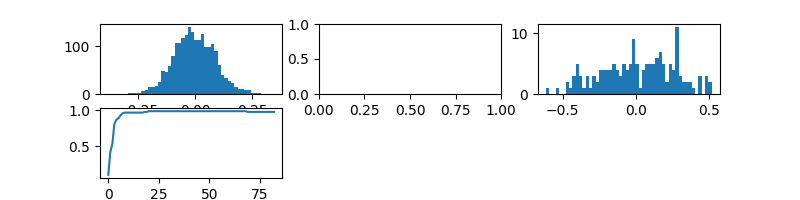

KeyboardInterrupt: 

In [40]:
def relu(z, derivative=False):
    if derivative:
        return 1 if z > 0 else 0
    
    return max(0, z)

def accuracy(net, test, labels):
    return np.mean([1 if np.argmax(net.predict(t)) == l else 0 for (t, l) in zip(test, labels)])

class Displayer:
    def __init__(self, net, test, labels):
        self.fig = plt.figure(figsize=(8, 2))
        self.net = net
        self.axs = [self.fig.add_subplot(2, len(net.layers), i+1) for i in range(len(net.layers))]
        self.accur_fig = self.fig.add_subplot(2, len(net.layers), len(net.layers)+1)
        self.accur = []
        self.test = test
        self.labels = labels
        
        
    def redraw(self):
        for (i, ax) in enumerate(self.axs):
            ax.clear()
            ax.hist(self.net.layers[i].weights.flatten(), bins=50)
            
        self.accur.append(accuracy(self.net, self.test, self.labels))
        self.accur_fig.clear()
        self.accur_fig.plot(self.accur)
        
        
        self.fig.canvas.draw()
        

        
        
l1 = Layer(64, 32)
l2 = Layer(32, 16)
l3 = Layer(16, 10, activation_fn=sigmoid)
net = Network(l1, l2, l3)


epochs = 100
batch_size = 5
learning_rate = .008

# the digit labels are the actual digit that the images corresponds to 0-9
# we have to convert this to a vector of probabilities that our network outputs
labels = np.array([label_to_vector(label) for label in digit_labels])
test_label_vectors = [label_to_vector(label) for label in test_labels]


print('=== TRAINING ===')

weight_hist = Displayer(net, test_set, test_labels)

for i in range(epochs):
    weight_hist.redraw()
    batch_train(net, digit_images, labels, 1, learning_rate, batch_size)
            